Ce nu e facut  
- webcam real-time blur, nici cod al meu nici cod din exemplu nu merge  
- salvare model antrenat de mine pentru torchscript cu torch.jit (2 tipuri de erori, 1 scrie ca e incompatibil cu operatiile, 2 o problema de mosteniri / redefiniri functii)  
                    in schimb am luat un model preantrenat pe acelasi scop (deeplabv3) ca sa pot folosi gradio si sa fac inferenta si afisare output

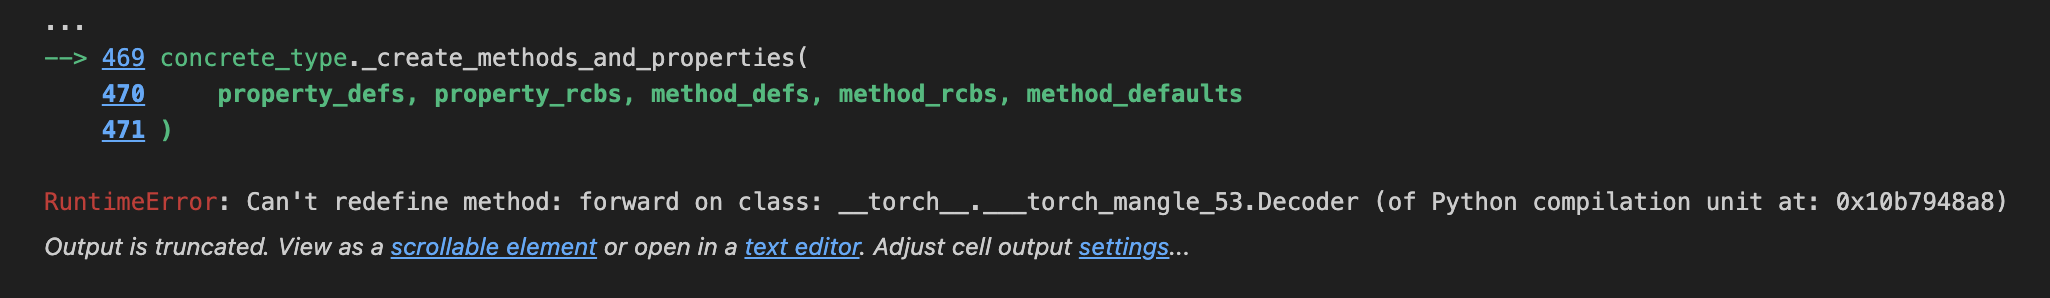

# Computer vision and deep learning - Laboratory 6

In this last laboratory, we will switch our focus from implementing and training neural networks to developing a machine learning application.
More specifically you will learn how you can convert your saved torch model into a more portable format using torch script and how you can create a simple demo application for your model.



In [5]:
!pip install gradio

## Converting your model into portable TorchScript binaries


``TorchScript`` allows you to create serializable and optimizable models from PyTorch code and then use them in a process where there is no Python dependency.


When deploying our module in production systems, we might need to run the model using another programming language (not Python) and even on mobile or embedded devices. In addition, we need a more lightweight environment than the development one.


Until now, when training a model we've saved checkpoints and reloaded the weights when needed into the development environment. As the name suggests, the checkpoints contain additional information (such as optimizer states) which allows you to resume the training process. However, all this information is not required during inference.




``Torchscript`` allows you to create a lightweight and independent model artifact suitable for runtime via two different techniques: scripting and tracing. They are both used to convert a PyTorch model into a more optimized or deployable form.




Tracing involves capturing a model's execution trace by passing example inputs through the model and recording the operations executed. This creates a TorchScript representation of the model based on the traced operations. However, tracing might not capture all dynamic aspects of the model, especially if the model's behavior changes dynamically based on input data or control flow operations. Tracing is more focused on capturing the specific operations executed with example inputs, which might be more efficient but might not cover all dynamic behaviors of complex models.




Scripting, on the other hand, refers to converting a PyTorch model (built using PyTorch's dynamic computation graph with Python control flow, such as loops and if statements) into a TorchScript. This involves representing the model as a static computation graph that can be executed independently of Python. Scripting allows the model to be saved and run in environments where a Python interpreter might not be available. Scripting captures the entire model logic and can handle more complex models with Pythonic control flow, making it more flexible but potentially more complex.


Both techniques aim to transform PyTorch models into TorchScript representations, making them efficient for deployment in various environments or for optimized execution, albeit with different approaches. The choice between scripting and tracing depends on the specific use case, model complexity, and deployment requirements.

You can check out the [documentation](https://pytorch.org/docs/stable/jit.html) for further details on ``TorchScript``.



Below you have an example that demonstrates the conversion of a pre-trained ResNet-18 model from torchvision into a TorchScript and then loading and using the saved TorchScript model for inference:

In [8]:
# import os
# import stat
# os.chmod('/Users/cosmin/.cache', stat.S_IRWXU)
# os.environ['TORCH_HOME'] = '/Users/cosmin/Dev/Projects/CV/models'

In [9]:
import torch
import torchvision.models as models


model = models.resnet18(pretrained=True)
model.eval()

# Create a sample input tensor (change according to your model's input requirements)
example_input = torch.randn(1, 3, 224, 224)

# Script the model
scripted_model = torch.jit.script(model)

# Save the scripted model to a file
scripted_model.save("scripted_resnet18.pt")

The main steps of the process are:
- load the pre-trained model and set it to evaluation mode with model.eval().
- create a sample input tensor (example_input) that matches the expected input shape of the model.
- use ```torch.jit.script()``` to convert the model into a TorchScript representation.
- save the scripted model to a file using ```scripted_model.save()``` for later use or deployment.

Now, let's see how you can use the scripted model:

In [10]:
import torch
from PIL import Image
from io import BytesIO
import requests
import torchvision
from torchvision.models import  ResNet18_Weights
from torchvision import transforms



# Load the saved TorchScript model
model = torch.jit.load("scripted_resnet18.pt")


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


image_url = 'https://images.unsplash.com/photo-1611267254323-4db7b39c732c?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8M3x8Y3V0ZSUyMGNhdHxlbnwwfHwwfHx8MA%3D%3D'
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert('RGB')


input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension


with torch.no_grad():
    # run the scripted model
    output = model(input_batch)

weights = ResNet18_Weights.DEFAULT

class_names = weights.meta["categories"]

# Get the top 5 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

# Display top 5 predicted classes and their probabilities
for i in range(top5_prob.size(0)):
    class_idx = top5_catid[i].item()
    print(f"Prediction: {class_names[class_idx]}, Probability: {top5_prob[i].item():.4f}")

Prediction: tabby, Probability: 0.7649
Prediction: tiger cat, Probability: 0.1408
Prediction: Egyptian cat, Probability: 0.0876
Prediction: Persian cat, Probability: 0.0024
Prediction: lynx, Probability: 0.0013


Optionally, you can also save the torchscript binary into ```wandb```. In this way, you will have a connection link between the model that is running in production and the training runs that you logged during training.

# Creating a simple UI with gradio


[Gradio](https://www.gradio.app/docs/interface) is an open-source Python library used for creating customizable UI components for machine learning models with just a few lines of code. It greatly simplifies the process of building web-based interfaces to interact with ML models without requiring extensive knowledge of web development and allows you to quickly build an MVP and get feedback from the users.


To get an application running, you just need to specify three parameters:
1. the function to wrap the interface around.
2. what are the desired input components?
3. what are the desired output components?


This is achieved through the ``gradio.Interface`` class, the central component in gradio, responsible for creating the user interface for your machine learning model.


```
import gradio as gr
demo = gr.Interface(fn=image_classifier,
                    inputs="image",
                    outputs="label")


```


Once you've defined the gr.Interface, the launch() method is used to start the interface, making it accessible through a web browser.


```
demo.launch()
```


When the launch method is called, ```gradio``` launches a simple web server that serves the demo. If you specify ```share=True``` when calling the launch function, ```gradio``` will create a public link Can also be used to create a public link used by anyone to access the demo from their browser.


## Simple UI for image classification in gradio

Below you have an example of how you could use ```gradio``` to create a simple UI for an image classification problem.

In [21]:
import numpy as np
import gradio as gr

CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def softmax(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())


def classify_image(img):
    # img which is numpy array, convert like this : Image.open(BytesIO(response.content)).convert('RGB')
    image = Image.fromarray(img.astype('uint8'), 'RGB')
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension


    with torch.no_grad():
        # run the scripted model
        output = model(input_batch)
        confidences = output[0].numpy()
        confidences = {CLASSES[i]: float(confidences[i]) for i in range(len(CLASSES))}


    prediction = softmax(np.random.randn(10, ))
    # confidences = {CLASSES[i]: float(prediction[i]) for i in range(len(CLASSES))}
    print(confidences)
    return confidences

ui = gr.Interface(fn=classify_image,
             inputs=gr.Image(),
             outputs=gr.Label(num_top_classes=3),
             # TODO replace example1.png example2.png with some images from your device
            #examples=['example1.png', 'example2.png']
          )
ui.launch()

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


{'airplane': -1.4722484350204468, 'automobile': 0.7471808791160583, 'bird': 0.299993097782135, 'cat': 0.040059804916381836, 'deer': 1.0278432369232178, 'dog': 0.4934355318546295, 'frog': -0.3195675015449524, 'horse': -0.10245770215988159, 'ship': 0.9225888252258301, 'truck': -2.1080973148345947}
{'airplane': 0.11138319969177246, 'automobile': -1.6972553730010986, 'bird': -1.5763559341430664, 'cat': -2.999220132827759, 'deer': -2.9108328819274902, 'dog': -2.469552516937256, 'frog': -2.5230655670166016, 'horse': -1.3935004472732544, 'ship': -1.6573972702026367, 'truck': 0.43958210945129395}


## Accessing the webcam with gradio

In the example below, you have an example in which you take the input images from your webcam.
The function wrapped by gradio uses a mask to blur the input image outside that mask. If you plan to do background blurring, the mask could be the segmentation mask predicted by your model.



In [77]:
import cv2
import gradio as gr
import numpy as np


# model = torch.jit.load("../lab5/unet.pth")
# model.eval()


def blur_background(input_image):
    input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
    # transform = transforms.Compose([
    #         transforms.Resize(250),
    #         transforms.ToTensor(),
    #     ])
    # # apply transform to input_image
    # input_image = transform(input_image)
    # Generate a blank mask
    # TODO your code here: call a segmentation model to get predicted mask
    # load "unet.pth" using torch.jit from "../lab5/unet.pth"
    # with torch.no_grad():
    #     mask = model(input_image)
    
    mask = np.zeros_like(input_image)

    # for demo purposes, we are going to create a random segmentation mask
    #  just a circular blob centered in the middle of the image
    center_x, center_y = mask.shape[1] // 2, mask.shape[0] // 2
    cv2.circle(mask, (center_x, center_y), 100, (255, 255, 255), -1)

    # Convert the mask to grayscale
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask_gray = mask_gray[:,:,np.newaxis]



    # apply a strong Gaussian blur to the areas outside the mask
    blurred = cv2.GaussianBlur(input_image, (51, 51), 0)
    result = np.where(mask_gray, input_image, blurred)

    # Convert the result back to RGB format for Gradio
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result


ui = gr.Interface(
    fn=blur_background,
    inputs=gr.Image(sources=["webcam"],streaming=True),
    outputs="image",
    title="Image segmentation demo!",
    live=True,


)
ui.launch(share= True)

Running on local URL:  http://127.0.0.1:7919
Running on public URL: https://7e1deabcc802d6d866.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/uvicorn/protocols/http/h11_impl.py", line 408, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/uvicorn/middleware/proxy_headers.py", line 84, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/starlette/applications.py", line 116, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/Users/

[[[154 180 205]
  [155 179 205]
  [155 179 205]
  ...
  [221 238 254]
  [220 237 253]
  [220 237 253]]

 [[153 179 204]
  [154 180 205]
  [155 179 205]
  ...
  [224 240 255]
  [222 239 255]
  [221 238 254]]

 [[153 179 204]
  [153 179 204]
  [154 180 205]
  ...
  [224 240 255]
  [223 239 254]
  [223 239 254]]

 ...

 [[121 109 109]
  [119 109 108]
  [117 107 106]
  ...
  [ 22  32  41]
  [ 23  36  44]
  [ 26  39  47]]

 [[118 106 106]
  [117 107 106]
  [114 104 103]
  ...
  [ 22  51  65]
  [ 22  54  69]
  [ 21  53  68]]

 [[128 116 118]
  [130 118 120]
  [130 115 118]
  ...
  [ 15  56  76]
  [  9  52  71]
  [  0  45  66]]]


In [2]:
# permission denied fixer
import os
# import stat
# os.chmod('/Users/cosmin/.cache', stat.S_IRWXU)
os.environ['TORCH_HOME'] = '/Users/cosmin/Dev/Projects/CV/models'

In [3]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import GaussianBlur
from torchvision.transforms.functional import gaussian_blur
import gradio as gr

# Load the pretrained DeepLabV3 model with a ResNet backbone
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

torch.save(model.state_dict(), 'deeplabv3.pth')

# Save the model's architecture to a script module
script_module = torch.jit.script(model)
script_module_save_path = 'deeplabv3_resnet101_script_module.pth'
torch.jit.save(script_module, script_module_save_path)

# Define a function to perform background blur using the pretrained model
def background_blur(image):
    print(image)
    # Preprocess the input image
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(image).unsqueeze(0)

    # Perform semantic segmentation using the pretrained model
    with torch.no_grad():
        output = model(input_image)['out'][0]
    output_predictions = output.argmax(0)

    # Create a mask for the background (non-person) pixels
    background_mask = (output_predictions != 15)  # Assuming person class index is 15

    # Convert the image and background mask to torch tensor
    image_tensor = transform(image).unsqueeze(0)
    background_mask_tensor = background_mask.unsqueeze(0).float()

    # Apply a Gaussian blur to the background using torchvision
    # blurred_background_tensor = GaussianBlur(kernel_size=11)(
    #     # image_tensor * (1 - background_mask_tensor)
    #     background_mask_tensor
    # )
    blurred = gaussian_blur(image_tensor, kernel_size=[25,25])
    #apply gaussian blur to background_mask_tensor
    blurred_background_tensor = blurred * background_mask_tensor
    
    # Replace the background pixels with the blurred background
    # result_image = image_tensor * (1 - background_mask_tensor) + blurred_background_tensor * background_mask_tensor
    result_image = image_tensor * (1 - background_mask_tensor) + blurred_background_tensor
    

    # Convert the result back to a PIL image
    result_image_pil = transforms.ToPILImage()(result_image.squeeze())

    return result_image_pil
    
# Create a Gradio interface to test the background blur function
iface = gr.Interface(fn=background_blur, inputs="image", outputs="image", live=True)
iface.launch()

Using cache found in /Users/cosmin/Dev/Projects/CV/models/hub/pytorch_vision_v0.10.0
/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/cosmin/Dev/.venv/lib/python3.11/site-packages/torch/jit/_recursive.py:312: UserWarning: 'aux_classifier' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[[[154 180 205]
  [155 179 205]
  [155 179 205]
  ...
  [221 238 254]
  [220 237 253]
  [220 237 253]]

 [[153 179 204]
  [154 180 205]
  [155 179 205]
  ...
  [224 240 255]
  [222 239 255]
  [221 238 254]]

 [[153 179 204]
  [153 179 204]
  [154 180 205]
  ...
  [224 240 255]
  [223 239 254]
  [223 239 254]]

 ...

 [[121 109 109]
  [119 109 108]
  [117 107 106]
  ...
  [ 22  32  41]
  [ 23  36  44]
  [ 26  39  47]]

 [[118 106 106]
  [117 107 106]
  [114 104 103]
  ...
  [ 22  51  65]
  [ 22  54  69]
  [ 21  53  68]]

 [[128 116 118]
  [130 118 120]
  [130 115 118]
  ...
  [ 15  56  76]
  [  9  52  71]
  [  0  45  66]]]


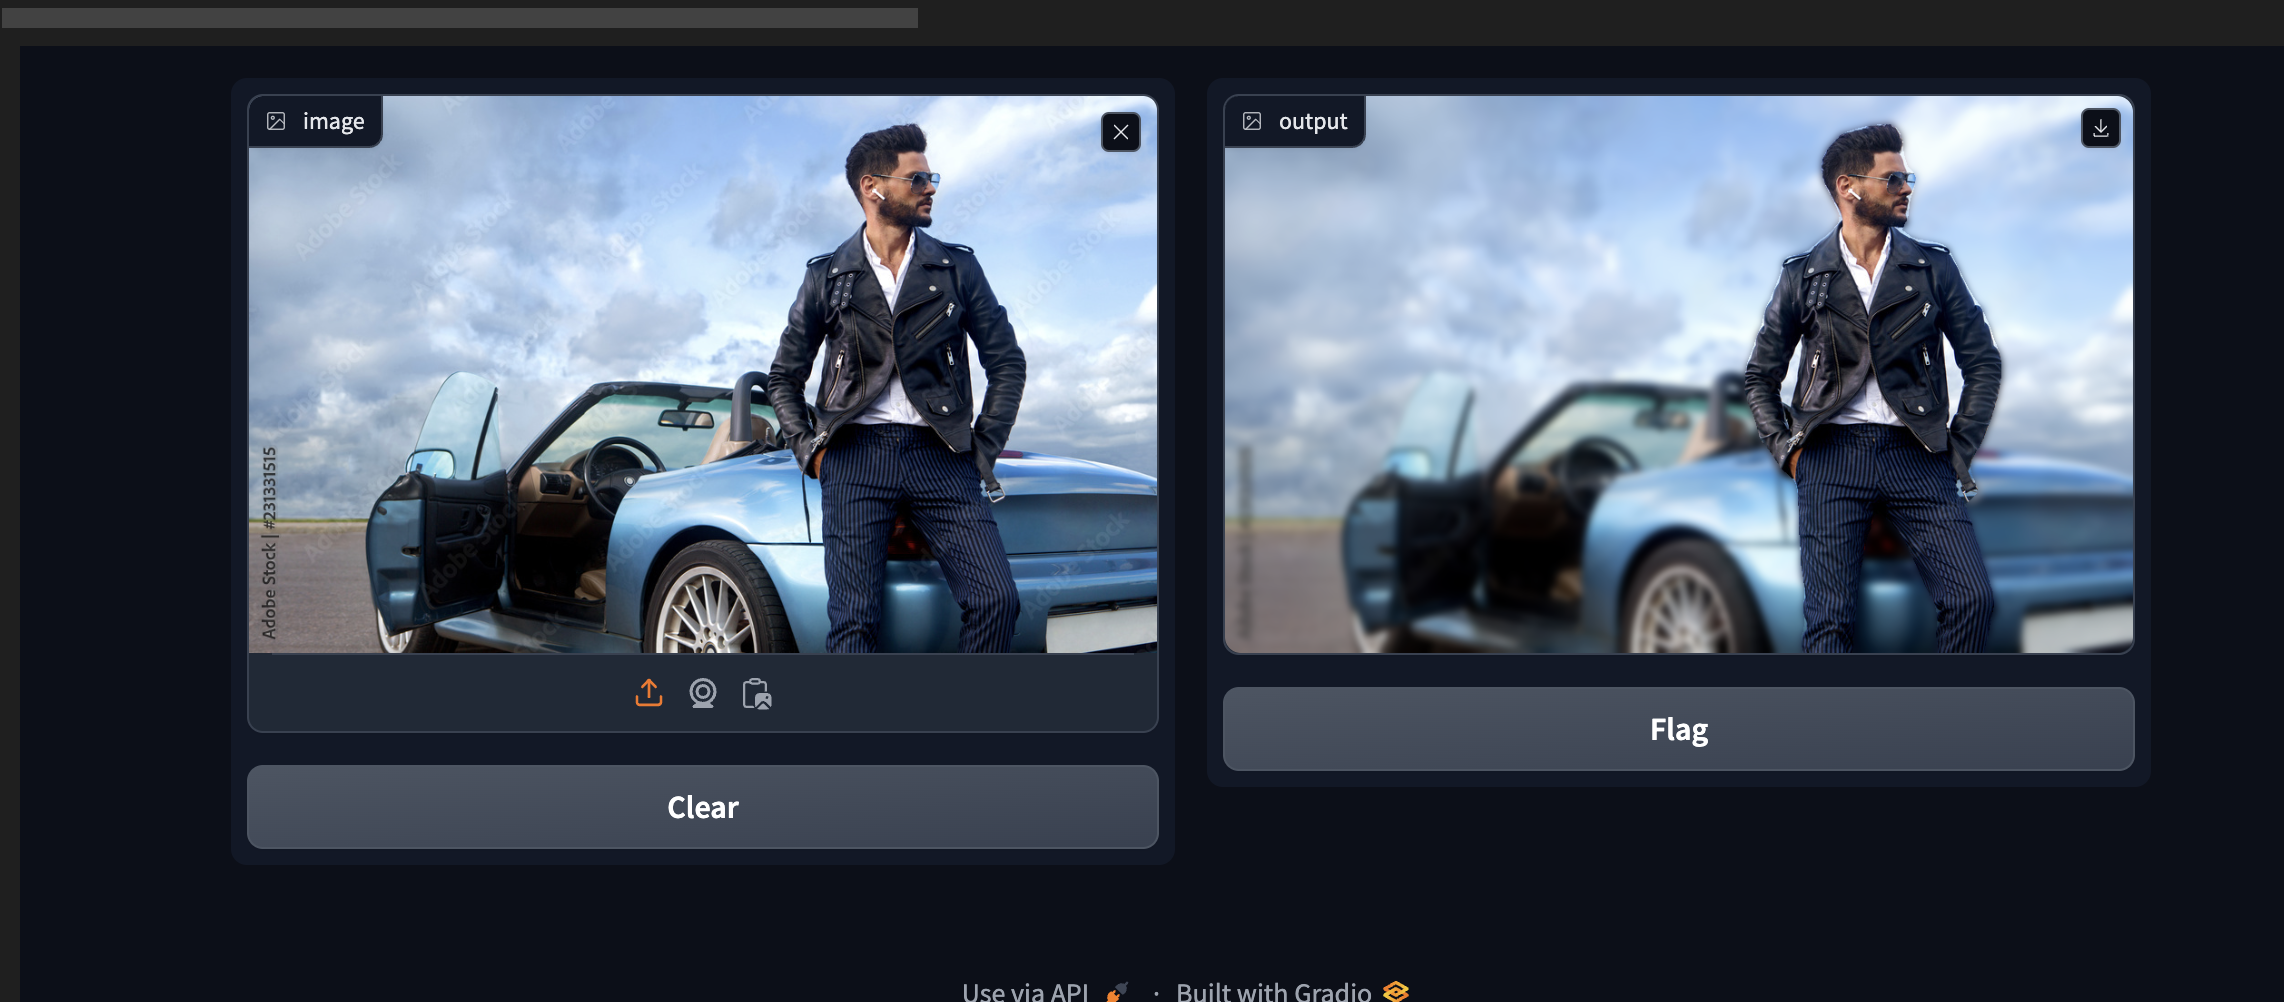

## Laboratory assignment


Now you have all the knowledge required to build your own ML semantic segmentation application.


1. First use ```torchscript``` to obtain a model binary.
2. Using gradio, create a simple application that uses the semantic segmentation that you developed. Feel free to define the scope and the functional requirements of your app.
3. __[Optional, independent work]__ Use a serverless cloud function on [AWS Lambda](https://aws.amazon.com/lambda/) (this requires an account on Amazon AWS and you need to provide the details of a credit card) to run the prediction and get the results.


Congratulations, you've just completed all the practical work for Computer Vision and Deep Learning!
May your data always be clean, your models accurate, and your code bug-free!



